# Reinforcement Learning Notebook - Get expert trajectories - Pendulum-v0

##### In this notebook we aim at saving several expert trajectories one by one whith different length of the pendulum and then use them as the expert trajectories

In [5]:
import gym
import numpy as np
import cvxpy as cp
import sys
import pylab
import pandas as pd 
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
import random
import torch.nn as nn
import math
from itertools import count
from PIL import Image
import torch
import torch.optim 
import torchvision.transforms as transforms
from collections import namedtuple, deque
from torch import nn
from gym import make
import torch.optim as optim
from numpy import save
from tqdm.notebook import tqdm
import pickle
from typing import Optional
import IPython
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
from Code.utils import Net, Agent, Memory
from Code.plotting import preprocess_states, animate

### DQN - Save expert trajectories

In [5]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [6]:
def main(environment, length):

    env = gym.make(environment)
    env.env.l = length 

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.shape[0]
    action_dim = env.action_space.shape[0] * 5 #discretization  of the unique continuous action of the pendulum

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0

    full_trajs = [] #supposed to be a list of arrays that will save several expert traj
    episodes = 300

    for i_ep in tqdm(range(episodes)):
        score = 0
        
        #We fix the departure state 
        state = env.reset()
        env.env.state = np.array([np.pi/2, 0.5])
        env.env.last_u = None
        state = env.env._get_obs()
        
        #to make it more robust we have to use :
        #state = env.reset()
        
        full_traj = state.reshape(1,-1)
        for t in range(1, 200):
            action, action_index = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            full_traj = np.concatenate((full_traj, np.array(state_).reshape(1,-1)))
            score += reward

            env.render()
            agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )
        
        if i_ep > episodes - 3:
            full_trajs.append(full_traj)


    agent.save_param()
    with open('/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_training_records_%s_length%s.pkl'%(environment,length), 'wb') as f:
        pickle.dump(training_records, f)
        
    save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment),full_trajs[-1])       
    #save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_exp_states_%s.npy'%environment,full_trajs[-1])
    #save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/multi_exp_states_%s.npy'%environment,full_trajs)

    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
    plt.title('DQN reward curve')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.savefig("/Users/ilanasebag/Documents/Thesis_Code/RL_results/dqn_%s_length%s.png"%(environment,length))
    plt.show()


Ep 0 Average score: -1041.1814315949262 score of current env -1411.8143159492618
Ep 1 Average score: -1057.3464352100189 score of current env -1202.8314677458516
Ep 2 Average score: -1094.9818935777396 score of current env -1433.7010188872268
Ep 3 Average score: -1104.5263293982491 score of current env -1190.4262517828345
Ep 4 Average score: -1105.2106883529566 score of current env -1111.3699189453243
Ep 5 Average score: -1129.8729257764314 score of current env -1351.833062587705
Ep 6 Average score: -1132.2053753525865 score of current env -1153.1974215379812
Ep 7 Average score: -1137.9166206046075 score of current env -1189.3178278727946
Ep 8 Average score: -1171.1989024875038 score of current env -1470.7394394335704
Ep 9 Average score: -1197.2670284297187 score of current env -1431.8801619096528


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -1190.344994132691 score of current env -1128.0466854594429
Ep 11 Average score: -1207.618154383006 score of current env -1363.0765966358406
Ep 12 Average score: -1221.5682694077423 score of current env -1347.1193046303679
Ep 13 Average score: -1248.648559539648 score of current env -1492.371170726798
Ep 14 Average score: -1270.1341166028626 score of current env -1463.504130171794
Ep 15 Average score: -1277.2667966751178 score of current env -1341.4609173254141
Ep 16 Average score: -1297.1695661384829 score of current env -1476.294491308768
Ep 17 Average score: -1304.5168268096409 score of current env -1370.642172850062
Ep 18 Average score: -1294.699541004865 score of current env -1206.3439687618834
Ep 19 Average score: -1272.8104629383383 score of current env -1075.8087603395988
Ep 20 Average score: -1227.1060827795432 score of current env -815.7666613503849
Ep 21 Average score: -1185.9203231928138 score of current env -815.248486912248
Ep 22 Average score: -1184.

Ep 111 Average score: -123.46704291308802 score of current env -124.30042476911612
Ep 112 Average score: -213.47808104772125 score of current env -1023.5774242594201
Ep 113 Average score: -217.70671802524916 score of current env -255.76445082300043
Ep 114 Average score: -208.3276673743144 score of current env -123.91621151590117
Ep 115 Average score: -273.05863433252796 score of current env -855.6373369564499
Ep 116 Average score: -271.221717140813 score of current env -254.68946241537816
Ep 117 Average score: -256.3143256663947 score of current env -122.14780239663055
Ep 118 Average score: -243.02402945170223 score of current env -123.41136351946966
Ep 119 Average score: -295.89917317132915 score of current env -771.7754666479714
Ep 120 Average score: -278.6025962042559 score of current env -122.9334035005968
Ep 121 Average score: -263.27763132213096 score of current env -125.35294738300618
Ep 122 Average score: -275.0562175639306 score of current env -381.06349374012717
Ep 123 Averag

Ep 211 Average score: -120.54850579246693 score of current env -120.29912878460057
Ep 212 Average score: -120.52040745351171 score of current env -120.2675224029147
Ep 213 Average score: -120.50054694405344 score of current env -120.321802358929
Ep 214 Average score: -120.4725436407413 score of current env -120.22051391093211
Ep 215 Average score: -120.45112803775541 score of current env -120.25838761088237
Ep 216 Average score: -120.4306897655428 score of current env -120.24674531562925
Ep 217 Average score: -120.41399622745702 score of current env -120.26375438468506
Ep 218 Average score: -120.39931670832573 score of current env -120.267201036144
Ep 219 Average score: -120.3825258722071 score of current env -120.23140834713946
Ep 220 Average score: -120.37935830402454 score of current env -120.3508501903815
Ep 221 Average score: -120.36413165112197 score of current env -120.22709177499871
Ep 222 Average score: -120.36124602547257 score of current env -120.33527539462794
Ep 223 Averag

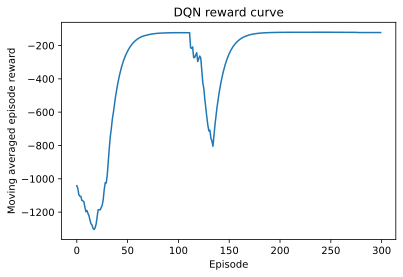

In [5]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    main(environment, 1.2)

Ep 0 Average score: -1033.2196725211452 score of current env -1332.1967252114507
Ep 1 Average score: -1067.0533534090318 score of current env -1371.5564814000122
Ep 2 Average score: -1107.9106449973924 score of current env -1475.6262692926366
Ep 3 Average score: -1150.178678262929 score of current env -1530.5909776527592
Ep 4 Average score: -1176.0187432225616 score of current env -1408.5793278592548
Ep 5 Average score: -1181.9520377475667 score of current env -1235.351688472612
Ep 6 Average score: -1189.2673801229887 score of current env -1255.1054615017863
Ep 7 Average score: -1208.4900693057716 score of current env -1381.4942719508165
Ep 8 Average score: -1218.0588111960903 score of current env -1304.1774882089583
Ep 9 Average score: -1228.307454061051 score of current env -1320.5452398456955


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -1234.0166729939647 score of current env -1285.3996433901887
Ep 11 Average score: -1219.8657340811885 score of current env -1092.5072838662036
Ep 12 Average score: -1195.9008325831596 score of current env -980.216719100899
Ep 13 Average score: -1170.649541322218 score of current env -943.3879199737421
Ep 14 Average score: -1147.9233791873705 score of current env -943.3879199737421
Ep 15 Average score: -1120.774208951181 score of current env -876.4316768254762
Ep 16 Average score: -1105.755507730632 score of current env -970.5871967456915
Ep 17 Average score: -1094.8130948423689 score of current env -996.3313788479994
Ep 18 Average score: -1017.5500859957182 score of current env -322.1830063758617
Ep 19 Average score: -1010.8765607773217 score of current env -950.8148338117545
Ep 20 Average score: -973.762072003203 score of current env -639.7316730361339
Ep 21 Average score: -906.5599204301665 score of current env -301.7405562728381
Ep 22 Average score: -862.0084446

Ep 111 Average score: -118.55250534632084 score of current env -117.18103349887964
Ep 112 Average score: -118.5403502204099 score of current env -118.4309540872114
Ep 113 Average score: -118.85195382219914 score of current env -121.65638623830219
Ep 114 Average score: -118.83562592862138 score of current env -118.68867488642157
Ep 115 Average score: -118.80605231062026 score of current env -118.53988974861008
Ep 116 Average score: -118.74576488588232 score of current env -118.20317806324084
Ep 117 Average score: -118.78206868297963 score of current env -119.10880285685532
Ep 118 Average score: -118.73454415159449 score of current env -118.30682336912828
Ep 119 Average score: -118.84027232358129 score of current env -119.79182587146236
Ep 120 Average score: -118.8155815158725 score of current env -118.59336424649328
Ep 121 Average score: -119.69249894239546 score of current env -127.58475578110206
Ep 122 Average score: -120.4355854903852 score of current env -127.12336442229277
Ep 123 A

Ep 211 Average score: -118.33347914642997 score of current env -119.01506779448049
Ep 212 Average score: -118.14264277592557 score of current env -116.42511544138607
Ep 213 Average score: -118.15916653316715 score of current env -118.30788034834141
Ep 214 Average score: -118.73030354303573 score of current env -123.87053663185301
Ep 215 Average score: -118.49595238827732 score of current env -116.38679199545156
Ep 216 Average score: -118.5599263669147 score of current env -119.13569217465111
Ep 217 Average score: -118.6500305363541 score of current env -119.46096806130862
Ep 218 Average score: -118.5164805562711 score of current env -117.3145307355242
Ep 219 Average score: -118.43434555021065 score of current env -117.69513049566656
Ep 220 Average score: -118.35857625273671 score of current env -117.67665257547117
Ep 221 Average score: -118.36147074381091 score of current env -118.38752116347877
Ep 222 Average score: -119.08396930858154 score of current env -125.58645639151712
Ep 223 A

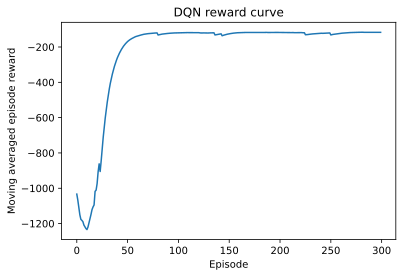

In [7]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    main(environment, 0.5)

Ep 0 Average score: -1003.3012981159649 score of current env -1033.0129811596487
Ep 1 Average score: -1005.5746116050558 score of current env -1026.0344330068745
Ep 2 Average score: -1025.1906152816352 score of current env -1201.7346483708504
Ep 3 Average score: -1041.192313378806 score of current env -1185.2075962533427
Ep 4 Average score: -1042.7685120938309 score of current env -1056.9543005290554
Ep 5 Average score: -1061.0288415524942 score of current env -1225.3718066804638
Ep 6 Average score: -1044.1805631246243 score of current env -892.5460572737942
Ep 7 Average score: -1046.3628687552764 score of current env -1066.0036194311447
Ep 8 Average score: -1047.5909115667287 score of current env -1058.6432968697993
Ep 9 Average score: -1033.3943404222064 score of current env -905.6252001215046
Ep 10 Average score: -1046.9673132506794 score of current env -1169.1240687069374
Ep 11 Average score: -1034.1729705270918 score of current env -919.0238860148031
Ep 12 Average score: -1037.997

Ep 102 Average score: -164.7043155101441 score of current env -126.35476984439921
Ep 103 Average score: -160.87132453333183 score of current env -126.37440574202122
Ep 104 Average score: -157.42428551180305 score of current env -126.40093431804387
Ep 105 Average score: -154.32085773645625 score of current env -126.39000775833486
Ep 106 Average score: -151.53162547742926 score of current env -126.4285351461861
Ep 107 Average score: -149.01879522297392 score of current env -126.40332293287581
Ep 108 Average score: -146.75614448475434 score of current env -126.39228784077808
Ep 109 Average score: -144.7213204771262 score of current env -126.40790440847303
Ep 110 Average score: -142.97340954957394 score of current env -127.24221120160364
Ep 111 Average score: -141.69825307372903 score of current env -130.22184479112468
Ep 112 Average score: -140.16510057727467 score of current env -126.36672810918549
Ep 113 Average score: -138.94364379410678 score of current env -127.95053274559557
Ep 114 

Ep 202 Average score: -463.9335444140579 score of current env -127.0991490179409
Ep 203 Average score: -458.9069207526274 score of current env -413.6673077997527
Ep 204 Average score: -483.57265513936 score of current env -705.564264619953
Ep 205 Average score: -461.3107502019549 score of current env -260.9536057653085
Ep 206 Average score: -440.97643905229336 score of current env -257.9676387053391
Ep 207 Average score: -409.6304670770206 score of current env -127.51671929956599
Ep 208 Average score: -381.4702665924903 score of current env -128.02846223171764
Ep 209 Average score: -355.9991022763774 score of current env -126.75862343136141
Ep 210 Average score: -333.1011132276303 score of current env -127.0192117889064
Ep 211 Average score: -312.47711861002455 score of current env -126.86116705157242
Ep 212 Average score: -293.898157490386 score of current env -126.68750741363935
Ep 213 Average score: -277.20515893084894 score of current env -126.96817189501526
Ep 214 Average score: -

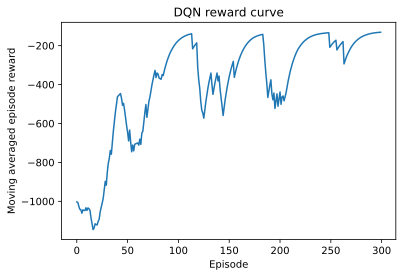

In [8]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    main(environment, 1.5)

Ep 0 Average score: -1061.3080421874083 score of current env -1613.0804218740825
Ep 1 Average score: -1102.7714650775033 score of current env -1475.9422710883575
Ep 2 Average score: -1144.948947867244 score of current env -1524.5462929749092
Ep 3 Average score: -1185.5290841997858 score of current env -1550.7503111926608
Ep 4 Average score: -1201.9231067465314 score of current env -1349.4693096672434
Ep 5 Average score: -1236.7417830931463 score of current env -1550.1098702126806
Ep 6 Average score: -1266.7917348704855 score of current env -1537.2413008665385
Ep 7 Average score: -1307.9496327788195 score of current env -1678.3707139538253
Ep 8 Average score: -1333.7013064402631 score of current env -1565.4663693932541
Ep 9 Average score: -1352.1444795825714 score of current env -1518.1330378633454
Ep 10 Average score: -1366.6106525580878 score of current env -1496.8062093377362
Ep 11 Average score: -1393.818461509463 score of current env -1638.6887420718406
Ep 12 Average score: -1326.2

Ep 101 Average score: -109.85113121515829 score of current env -100.09107729943933
Ep 102 Average score: -110.25483658546942 score of current env -113.88818491826954
Ep 103 Average score: -109.47173104844013 score of current env -102.42378121517665
Ep 104 Average score: -108.71652815270261 score of current env -101.91970209106485
Ep 105 Average score: -108.68951411654474 score of current env -108.44638779112385
Ep 106 Average score: -108.19995864449038 score of current env -103.7939593960012
Ep 107 Average score: -109.66825017148825 score of current env -122.88287391446912
Ep 108 Average score: -109.1151903949462 score of current env -104.13765240606767
Ep 109 Average score: -108.81448360846173 score of current env -106.1081225301015
Ep 110 Average score: -108.96241421701629 score of current env -110.29378969400717
Ep 111 Average score: -110.55586695368476 score of current env -124.89694158370106
Ep 112 Average score: -110.18079745320324 score of current env -106.80517194886959
Ep 113 

Ep 201 Average score: -106.60087524186933 score of current env -105.66888867488716
Ep 202 Average score: -106.47646955521051 score of current env -105.35681837528124
Ep 203 Average score: -105.9882423692551 score of current env -101.5941976956564
Ep 204 Average score: -106.24533506052074 score of current env -108.55916928191142
Ep 205 Average score: -105.95394725236798 score of current env -103.33145697899307
Ep 206 Average score: -107.48098317980441 score of current env -121.2243065267323
Ep 207 Average score: -106.72279581767509 score of current env -99.8991095585112
Ep 208 Average score: -106.0658668076954 score of current env -100.15350571787815
Ep 209 Average score: -105.91598492346856 score of current env -104.56704796542691
Ep 210 Average score: -105.68422653972753 score of current env -103.5984010860582
Ep 211 Average score: -105.22541236183929 score of current env -101.09608476084509
Ep 212 Average score: -106.38644637931083 score of current env -116.83575253655465
Ep 213 Aver

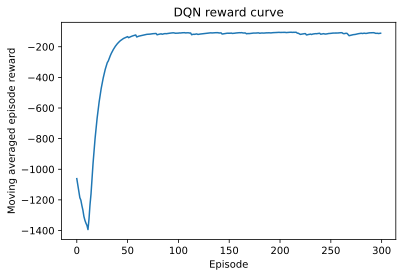

In [9]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    main(environment, 0.3)

Ep 0 Average score: -1004.8833767482254 score of current env -1048.8337674822533
Ep 1 Average score: -1027.3080605503687 score of current env -1229.130214769658
Ep 2 Average score: -1019.1077271654757 score of current env -945.304726701438
Ep 3 Average score: -1008.8337873578771 score of current env -916.3683290894894
Ep 4 Average score: -1002.1805950773954 score of current env -942.3018645530603
Ep 5 Average score: -994.9565416639231 score of current env -929.940060942672
Ep 6 Average score: -1002.8013826644004 score of current env -1073.4049516686964
Ep 7 Average score: -1016.2193391623812 score of current env -1136.980947644208
Ep 8 Average score: -1008.1305796708497 score of current env -935.3317442470652
Ep 9 Average score: -1008.1376684807955 score of current env -1008.2014677703077


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -1007.0236272858587 score of current env -996.997256531428
Ep 11 Average score: -1023.0554678409615 score of current env -1167.342032836886
Ep 12 Average score: -1026.4297292328815 score of current env -1056.798081760162
Ep 13 Average score: -1063.2722771811016 score of current env -1394.855208715081
Ep 14 Average score: -1098.399565566143 score of current env -1414.5451610315176
Ep 15 Average score: -1127.5807599674085 score of current env -1390.2115095787972
Ep 16 Average score: -1129.4647587854242 score of current env -1146.4207481475637
Ep 17 Average score: -1145.7829482955142 score of current env -1292.6466538863228
Ep 18 Average score: -1173.14931134922 score of current env -1419.4465788325724
Ep 19 Average score: -1169.933262401687 score of current env -1140.9888218738922
Ep 20 Average score: -1142.4480985144028 score of current env -895.0816235288459
Ep 21 Average score: -1133.1547000716478 score of current env -1049.5141140868525
Ep 22 Average score: -1138

Ep 112 Average score: -140.92383488587282 score of current env -130.97159215187864
Ep 113 Average score: -140.18223550471126 score of current env -133.50784107425716
Ep 114 Average score: -139.25950133486091 score of current env -130.9548938062077
Ep 115 Average score: -138.9771099802014 score of current env -136.4355877882656
Ep 116 Average score: -138.18180098200094 score of current env -131.0240199981968
Ep 117 Average score: -137.46507353402666 score of current env -131.01452650225824
Ep 118 Average score: -136.81901088564945 score of current env -131.00444705025438
Ep 119 Average score: -136.52548715069108 score of current env -133.8837735360658
Ep 120 Average score: -136.14538529535739 score of current env -132.72446859735416
Ep 121 Average score: -135.6367798512271 score of current env -131.0593308540544
Ep 122 Average score: -135.37751819014431 score of current env -133.0441632403992
Ep 123 Average score: -134.93871199568756 score of current env -130.98945624557663
Ep 124 Avera

Ep 213 Average score: -266.9546373981724 score of current env -265.1846260381155
Ep 214 Average score: -253.352413025445 score of current env -130.93239367089828
Ep 215 Average score: -241.11572174260345 score of current env -130.98550019702944
Ep 216 Average score: -230.09583835968246 score of current env -130.9168879133934
Ep 217 Average score: -220.18348088262985 score of current env -130.97226358915646
Ep 218 Average score: -211.43548286120145 score of current env -132.70350066834564
Ep 219 Average score: -203.38439189845525 score of current env -130.9245732337395
Ep 220 Average score: -196.14901819588954 score of current env -131.03065487279824
Ep 221 Average score: -189.65211232917179 score of current env -131.17995952871192
Ep 222 Average score: -183.94103378608034 score of current env -132.54132689825713
Ep 223 Average score: -178.77030075693781 score of current env -132.23370349465523
Ep 224 Average score: -173.9917536713689 score of current env -130.98482990124867
Ep 225 Aver

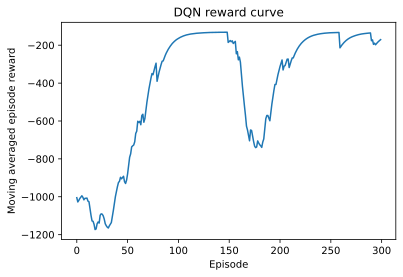

In [33]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    main(environment, 1.7)

Ep 0 Average score: -1031.4193813826412 score of current env -1314.1938138264127
Ep 1 Average score: -1042.9916563939075 score of current env -1147.1421314953036
Ep 2 Average score: -1071.612030229484 score of current env -1329.1953947496713
Ep 3 Average score: -1081.9631133982996 score of current env -1175.1228619176393
Ep 4 Average score: -1092.4827257920815 score of current env -1187.1592373361175
Ep 5 Average score: -1129.2027582212036 score of current env -1459.6830500833023
Ep 6 Average score: -1127.368727224131 score of current env -1110.8624482504774
Ep 7 Average score: -1153.3764226071903 score of current env -1387.4456810547247
Ep 8 Average score: -1175.0414908817088 score of current env -1370.0271053523747
Ep 9 Average score: -1180.5023708926674 score of current env -1229.6502909912954
Ep 10 Average score: -1174.6033089379027 score of current env -1121.5117513450198
Ep 11 Average score: -1182.2339472950418 score of current env -1250.9096925092954
Ep 12 Average score: -1203.6

Ep 101 Average score: -122.5310480749924 score of current env -118.4707793824658
Ep 102 Average score: -122.2549283118687 score of current env -119.76985044375532
Ep 103 Average score: -121.80154055307133 score of current env -117.72105072389513
Ep 104 Average score: -121.42488858374583 score of current env -118.03502085981614
Ep 105 Average score: -121.1238384711576 score of current env -118.41438745786353
Ep 106 Average score: -120.81287465569864 score of current env -118.01420031656795
Ep 107 Average score: -120.71987492846965 score of current env -119.88287738340873
Ep 108 Average score: -120.46149373423752 score of current env -118.13606298614829
Ep 109 Average score: -120.21776998613335 score of current env -118.02425625319574
Ep 110 Average score: -120.0071501444058 score of current env -118.11157156885783
Ep 111 Average score: -119.79214550019205 score of current env -117.85710370226825
Ep 112 Average score: -119.61265389529775 score of current env -117.99722945124908
Ep 113 Av

Ep 201 Average score: -121.15636841021954 score of current env -121.34053009072412
Ep 202 Average score: -121.24965696705105 score of current env -122.08925397853457
Ep 203 Average score: -121.38935765197145 score of current env -122.64666381625504
Ep 204 Average score: -121.68961198632046 score of current env -124.39190099546157
Ep 205 Average score: -134.4030678507639 score of current env -248.82417063075485
Ep 206 Average score: -133.1499435287988 score of current env -121.87182463111262
Ep 207 Average score: -132.05004338947143 score of current env -122.15094213552526
Ep 208 Average score: -130.8351659079531 score of current env -119.901268574288
Ep 209 Average score: -129.7260672644378 score of current env -119.74417947280001
Ep 210 Average score: -128.7975218916772 score of current env -120.4406135368319
Ep 211 Average score: -127.91552445826534 score of current env -119.9775475575585
Ep 212 Average score: -127.09996605836298 score of current env -119.75994045924165
Ep 213 Averag

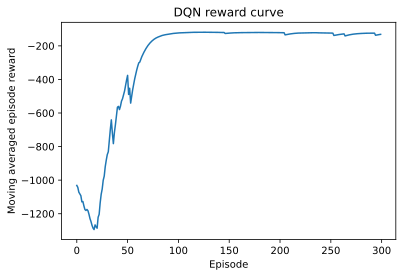

In [11]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    main(environment, 1)

### Save the expert trajectories

In [7]:
environment = 'Pendulum-v0'

In [8]:
length = 1.2 
exp1 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [9]:
length = 0.5
exp2 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [10]:
length = 1.5
exp3 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [11]:
length = 0.3
exp4 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [12]:
length = 1.7
exp5 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

In [13]:
length = 1
exp6 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/simple_l%s_exp_states_%s.npy'%(length,environment))

Save the following :
- 5 expert trajectories as arrays within an array
- all with different length of pendulum
- none with length = 1 (default length for pendulum)

In [41]:
t1 = 'multi_diff_lengths_excl_1'

e = []
e.append(exp1)
e.append(exp2)
e.append(exp3)
e.append(exp4)
e.append(exp5)
e = np.asarray(e)
print(e.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t1,environment), e)

(5, 200, 3)


Save the following :

- 5 expert trajectories as arrays within an array
- all with same length of pendulum
- length is > 1 (default length for pendulum) --> here we take 1.5

In [42]:
t2 = 'multi_same_lengths_1_5'

f = []
f.append(exp3)
f.append(exp3)
f.append(exp3)
f.append(exp3)
f.append(exp3)
f = np.asarray(f)
print(f.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t2,environment), f)

(5, 200, 3)


Save the following :

- 5 expert trajectories as arrays within an array
- all with same length of pendulum
- length is < 1 (default length for pendulum) --> here we take 0.3

In [43]:
t3 = 'multi_same_lengths_0_3'

k = []
k.append(exp4)
k.append(exp4)
k.append(exp4)
k.append(exp4)
k.append(exp4)
k = np.asarray(k)
print(k.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t3,environment), k)

(5, 200, 3)


Save the following :

- 5 expert trajectories as arrays within an array
- all with same length of pendulum
- length is  1 (default length for pendulum) 

In [20]:
t4 = 'multi_same_lengths_1'

g = []
g.append(exp6)
g.append(exp6)
g.append(exp6)
g.append(exp6)
g.append(exp6)
g = np.asarray(g)
print(g.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t4,environment), g)

(5, 200, 3)


In [22]:
t11 = 'multi_same_lengths_0_5'

g = []
g.append(exp2)
g.append(exp2)
g.append(exp2)
g.append(exp2)
g.append(exp2)
g = np.asarray(g)
print(g.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t11,environment), g)

(5, 200, 3)


In [23]:
t12 = 'multi_same_lengths_1_7'

g = []
g.append(exp5)
g.append(exp5)
g.append(exp5)
g.append(exp5)
g.append(exp5)
g = np.asarray(g)
print(g.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t12,environment), g)

(5, 200, 3)


In [24]:
t13 = 'multi_same_lengths_1_2'

g = []
g.append(exp1)
g.append(exp1)
g.append(exp1)
g.append(exp1)
g.append(exp1)
g = np.asarray(g)
print(g.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t13,environment), g)

(5, 200, 3)


Save the following :

- 1 expert trajectory 
- length is 1 (default length for pendulum)

In [45]:
t5 = 'simple_length_1'

h = []
h.append(exp6)
h = np.asarray(h)
print(h.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t5,environment), h)

(1, 200, 3)


Save the following :

- 1 expert trajectory 
- length > 1 (default length for pendulum) --> here 1.5

In [46]:
t6 = 'simple_length_1_5'

j = []
j.append(exp3)
j = np.asarray(j)
print(j.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t6,environment), j)

(1, 200, 3)


Save the following :

- 1 expert trajectory 
- length < 1 (default length for pendulum) --> here 0.3

In [47]:
t7 = 'simple_length_0_3'

m = []
m.append(exp4)
m = np.asarray(m)
print(m.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t7,environment), m)

(1, 200, 3)


In [15]:
t8 = 'simple_length_0_5'

m = []
m.append(exp2)
m = np.asarray(m)
print(m.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t8,environment), m)

(1, 200, 3)


In [17]:
t9 = 'simple_length_1_7'

m = []
m.append(exp5)
m = np.asarray(m)
print(m.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t9,environment), m)

(1, 200, 3)


In [18]:
t10 = 'simple_length_1_2'

m = []
m.append(exp1)
m = np.asarray(m)
print(m.shape)
save('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t10,environment), m)

(1, 200, 3)


### Visualization example

In [48]:
t1 = 'multi_diff_lengths_excl_1'
environment = 'Pendulum-v0'
traj1 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t1,environment))

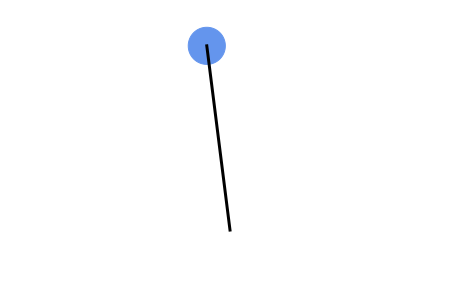

In [51]:
#Visualize the first expert saved in the array loaded above
states = preprocess_states(traj1[0]) 
animate(states)